# Assignment 1 - TD with State Aggregation

**Implement the following: **
 1. Semi-gradient TD(0) with function approximation(state aggregation)
 1. Supervised learning approaches to approximate value functions
 1. Also, compare the impact of different resolutions of state aggregation, and see first hand how function approximation can speed up learning through generalization


## 500-State RandomWalk Environment

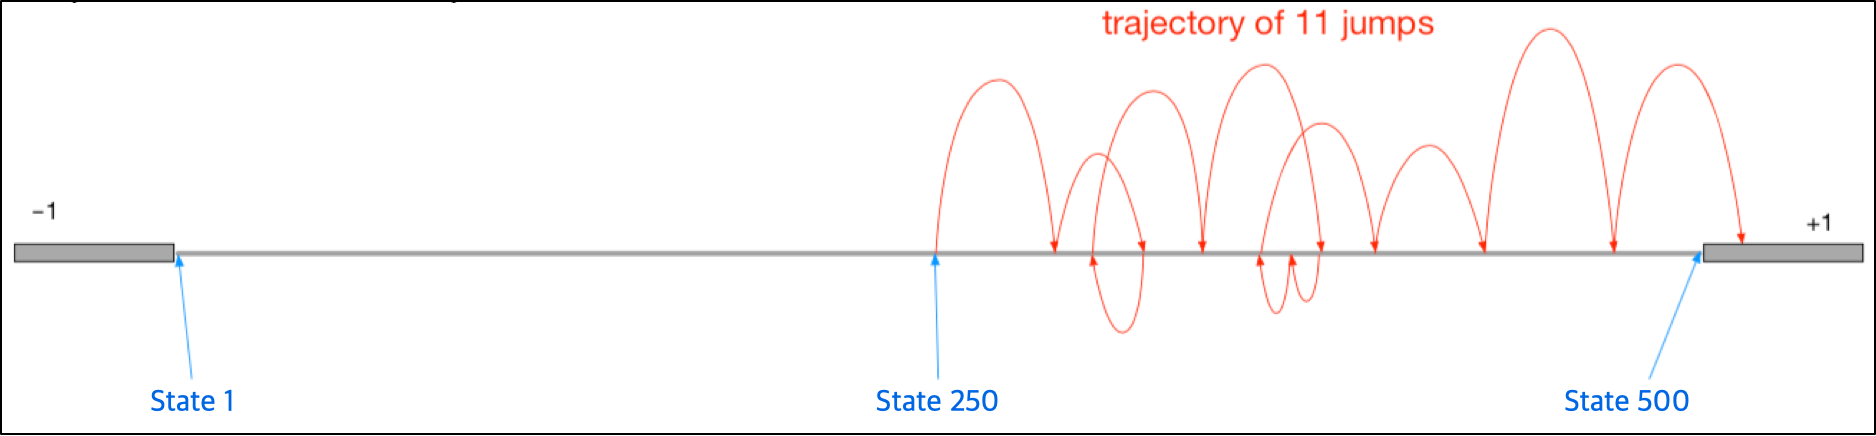

There are 500 states numbered from 1 to 500, left to right, and all episodes begin with the agent located at the center, in state 250. For simplicity, we will consider state 0 and state 501 as the left and right terminal states respectively.

The episode terminates when the agent reaches the terminal state (state 0) on the left, or the terminal state (state 501) on the right. Termination on the left (state 0) gives the agent a reward of -1, and termination on the right (state 501) gives the agent a reward of +1.

The agent can take one of two actions: go left or go right. If the agent chooses the left action, then it transitions uniform randomly into one of the 100 neighboring states to its left. If the agent chooses the right action, then it transitions randomly into one of the 100 neighboring states to its right.

States near the edge may have fewer than 100 neighboring states on that side. In this case, all transitions that would have taken the agent past the edge result in termination. If the agent takes the left action from state 50, then it has a 0.5 chance of terminating on the left. If it takes the right action from state 499, then it has a 0.99 chance of terminating on the right.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import jdc
from tqdm import tqdm
from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
import plot_script

 ## Section 1: Create the 500-State RandomWalk Environment

In [2]:
class RandomWalkEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        
        Set parameters needed to setup the 500-state random walk environment.
        
        Assume env_info dict contains:
        {
            num_states: 500 [int],
            start_state: 250 [int],
            left_terminal_state: 0 [int],
            right_terminal_state: 501 [int],
            seed: int
        }
        """
        
        self.rand_generator = np.random.RandomState(env_info.get("seed")) 
        
        self.num_states = env_info["num_states"] 
        self.start_state = env_info["start_state"] 
        self.left_terminal_state = env_info["left_terminal_state"] 
        self.right_terminal_state = env_info["right_terminal_state"]

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """

        reward = 0.0
        state = self.start_state
        is_terminal = False
                
        self.reward_state_term = (reward, state, is_terminal)
        
        return self.reward_state_term[1]
        
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """
        
        last_state = self.reward_state_term[1]
        
        if action == 0: # left
            current_state = max(self.left_terminal_state, last_state + self.rand_generator.choice(range(-100,0)))
        elif action == 1: # right
            current_state = min(self.right_terminal_state, last_state + self.rand_generator.choice(range(1,101)))
        else: 
            raise ValueError("Wrong action value")
        
        if current_state == self.left_terminal_state: 
            reward = -1.0
            is_terminal = True
        
        elif current_state == self.right_terminal_state:
            reward = 1.0
            is_terminal = True
        
        else:
            reward = 0.0
            is_terminal = False
        
        self.reward_state_term = (reward, current_state, is_terminal)
        
        return self.reward_state_term

## Section 2: Semi-gradient TD(0) Agent with State Aggregation

You will create an Agent that learns with semi-gradient TD(0) with state aggregation. For state aggregation, if the resolution (num_groups) is 10, then 500 states are partitioned into 10 groups of 50 states each (i.e., states 1-50 are one group, states 51-100 are another, and so on.)

Hence, 50 states would share the same feature and value estimate, and there would be 10 distinct features. The feature vector for each state is a one-hot feature vector of length 10, with a single one indicating the group for that state. (one-hot vector of length 10)

In [3]:
def agent_policy(rand_generator, state):
    """
    Given random number generator and state, returns an action according to the agent's policy.
    
    Args:
        rand_generator: Random number generator

    Returns:
        chosen action [int]
    """
    chosen_action = rand_generator.choice([0,1])
    
    return chosen_action

In [4]:
test_rand_generator = np.random.RandomState(99) 
state = 250

action_array = []
for i in range(10):
    action_array.append(agent_policy(test_rand_generator, 250))
    
print('action_array: {}'.format(action_array))

action_array: [1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


In [5]:
def get_state_feature(num_states_in_group, num_groups, state):
    """
    Given state, return the feature of that state
    
    Args:
        num_states_in_group [int]
        num_groups [int] 
        state [int] : 1~500

    Returns:
        one_hot_vector [numpy array]
    """
    
    one_hot_vector = np.zeros(num_groups)
    one_hot_vector[(state-1) // num_states_in_group] = 1
    
    return one_hot_vector

In [6]:
num_states = 10
num_groups = 5
num_states_in_group = int(num_states / num_groups)

# Test 1st group, state = 1
state = 1
print("1st group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 2nd group, state = 3
state = 3
print("2nd group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 3rd group, state = 6
state = 6
print("3rd group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 4th group, state = 7
state = 7
print("4th group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

# Test 5th group, state = 10
state = 10
print("5th group: {}".format(get_state_feature(num_states_in_group, num_groups, state)))

1st group: [1. 0. 0. 0. 0.]
2nd group: [0. 1. 0. 0. 0.]
3rd group: [0. 0. 1. 0. 0.]
4th group: [0. 0. 0. 1. 0.]
5th group: [0. 0. 0. 0. 1.]


In [7]:
class TDAgent(BaseAgent):
    def __init__(self):
        self.num_states = None
        self.num_groups = None
        self.step_size = None
        self.discount_factor = None
        
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            num_states: 500 [int],
            num_groups: int, 
            step_size: float, 
            discount_factor: float,
            seed: int
        }
        """

        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 

        self.num_states = agent_info.get("num_states")
        self.num_groups = agent_info.get("num_groups")
        self.step_size = agent_info.get("step_size")
        self.discount_factor = agent_info.get("discount_factor")

        num_states_in_group = int(self.num_states / self.num_groups)
        self.all_state_features = np.array([get_state_feature(num_states_in_group, self.num_groups, state) for state in range(1, self.num_states + 1)])

        self.weights = np.zeros(self.num_groups)

        self.last_state = None
        self.last_action = None

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """

        action = agent_policy(self.rand_generator, state)
        self.last_state = state
        self.last_action = action

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        
        current_state_feature = self.all_state_features[state-1] 
        last_state_feature = self.all_state_features[self.last_state-1] 
        
        self.weights += self.step_size * (reward + self.discount_factor * np.dot(self.weights, current_state_feature) - np.dot(self.weights, last_state_feature)) * last_state_feature
        action = agent_policy(self.rand_generator, state)
        self.last_state = state
        self.last_action = action
        
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        last_state_feature = self.all_state_features[self.last_state-1]
        
        self.weights += self.step_size * (reward - np.dot(self.weights, last_state_feature)) * last_state_feature
        return
        
    def agent_message(self, message):
        raise NotImplementedError

In [8]:

agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# check attributes
print("num_states: {}".format(test_agent.num_states))
print("num_groups: {}".format(test_agent.num_groups))
print("step_size: {}".format(test_agent.step_size))
print("discount_factor: {}".format(test_agent.discount_factor))

print("weights shape: {}".format(test_agent.weights.shape))
print("weights init. value: {}".format(test_agent.weights))

num_states: 500
num_groups: 10
step_size: 0.1
discount_factor: 1.0
weights shape: (10,)
weights init. value: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "seed": 1
             }

# Suppose state = 250
state = 250

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_agent.agent_start(state)

print("Agent state: {}".format(test_agent.last_state))
print("Agent selected action: {}".format(test_agent.last_action))

Agent state: 250
Agent selected action: 1


In [10]:
## Test Code for agent_step() ## 
# Make sure agent_init() and agent_start() are working correctly first.
# agent_step() should work correctly for other arbitrary state transitions in addition to this test case.
agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 0.9,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# Initializing the weights to arbitrary values to verify the correctness of weight update
test_agent.weights = np.array([-1.5, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0.0, -0.5, -1.0])
print("Initial weights: {}".format(test_agent.weights))

# Assume the agent started at State 50
start_state = 50
action = test_agent.agent_start(start_state)

# Assume the reward was 10.0 and the next state observed was State 120
reward = 10.0
next_state = 120
test_agent.agent_step(reward, next_state)
print("Updated weights: {}".format(test_agent.weights))

if np.allclose(test_agent.weights, np.array([-0.26, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0., -0.5, -1.])):
    print("weight update is correct!\n")
else:
    print("weight update is incorrect.\n")

print("last state: {}".format(test_agent.last_state))
print("last action: {}".format(test_agent.last_action))

Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
Updated weights: [-0.26  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]
weight update is correct!

last state: 120
last action: 1


In [11]:

agent_info = {"num_states": 500,
              "num_groups": 10,
              "step_size": 0.1,
              "discount_factor": 0.9,
              "seed": 1}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# Initializing the weights to arbitrary values to verify the correctness of weight update
test_agent.weights = np.array([-1.5, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0.0, -0.5, -1.0])
print("Initial weights: {}".format(test_agent.weights))

# Assume the agent started at State 50
start_state = 50
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and reached the terminal state
test_agent.agent_end(10.0)
print("Updated weights: {}".format(test_agent.weights))

if np.allclose(test_agent.weights, np.array([-0.35, 0.5, 1., -0.5, 1.5, -0.5, 1.5, 0., -0.5, -1.])):
    print("weight update is correct!\n")
else:
    print("weight update is incorrect.\n")

Initial weights: [-1.5  0.5  1.  -0.5  1.5 -0.5  1.5  0.  -0.5 -1. ]
Updated weights: [-0.35  0.5   1.   -0.5   1.5  -0.5   1.5   0.   -0.5  -1.  ]
weight update is correct!



In [12]:
%%add_to TDAgent


def agent_message(self, message):
    if message == 'get state value':
        state_value = np.dot(self.weights, self.all_state_features.T)
        
        return state_value

In [13]:
agent_info = {"num_states": 20,
              "num_groups": 5,
              "step_size": 0.1,
              "discount_factor": 1.0}

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_state_val = test_agent.agent_message('get state value')

print("State value shape: {}".format(test_state_val.shape))
print("Initial State value for all states: {}".format(test_state_val))

State value shape: (20,)
Initial State value for all states: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Section 3: Run Experiment

Now that we've implemented all the components of environment and agent, let's run an experiment! We will plot two things: 
- the learned state value function and compare it against the true state values
- a learning curve depicting the error in the learned value estimates over episodes.

In [14]:
true_state_val = np.load('data/true_V.npy')    
state_distribution = np.load('data/state_distribution.npy')

In [15]:
def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

In [16]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)
    
    for num_agg_states in agent_parameters["num_groups"]:
        for step_size in agent_parameters["step_size"]:
            
            agent_rmsve = np.zeros(int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1)

            agent_state_val = np.zeros(environment_parameters["num_states"])

            env_info = {"num_states": environment_parameters["num_states"],
                        "start_state": environment_parameters["start_state"],
                        "left_terminal_state": environment_parameters["left_terminal_state"],
                        "right_terminal_state": environment_parameters["right_terminal_state"]}

            agent_info = {"num_states": environment_parameters["num_states"],
                          "num_groups": num_agg_states,
                          "step_size": step_size,
                          "discount_factor": environment_parameters["discount_factor"]}

            print('Setting - num. agg. states: {}, step_size: {}'.format(num_agg_states, step_size))
            os.system('sleep 0.2')

            for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                env_info["seed"] = run
                agent_info["seed"] = run
                rl_glue.rl_init(agent_info, env_info)
                
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[0] += calc_RMSVE(current_V)
                    
                for episode in range(1, experiment_parameters["num_episodes"]+1):
                    rl_glue.rl_episode(0)
                    
                    if episode % experiment_parameters["episode_eval_frequency"] == 0:
                        current_V = rl_glue.rl_agent_message("get state value")
                        agent_rmsve[int(episode/experiment_parameters["episode_eval_frequency"])] += calc_RMSVE(current_V)
                        
                if run == 50:
                    agent_state_val = rl_glue.rl_agent_message("get state value")
            
            agent_rmsve /= experiment_parameters["num_runs"]
            
            save_name = "{}_agg_states_{}_step_size_{}".format('TD_agent', num_agg_states, step_size).replace('.','')
            
            if not os.path.exists('results'):
                os.makedirs('results')
    
            np.save("results/V_{}".format(save_name), agent_state_val)

            np.save("results/RMSVE_{}".format(save_name), agent_rmsve)

In [ ]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500, 
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501, 
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
agent_parameters = {
    "num_groups": [10],
    "step_size": [0.01, 0.05, 0.1]
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

Setting - num. agg. states: 10, step_size: 0.01


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Setting - num. agg. states: 10, step_size: 0.05


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:18<00:08,  1.75s/it]

In [ ]:
agent_parameters = {
    "num_groups": [10],
    "step_size": [0.01, 0.05, 0.1]
}

all_correct = True
for num_agg_states in agent_parameters["num_groups"]:
    for step_size in agent_parameters["step_size"]:
        filename = 'RMSVE_TD_agent_agg_states_{}_step_size_{}'.format(num_agg_states, step_size).replace('.','')
        agent_RMSVE = np.load('results/{}.npy'.format(filename))
        correct_RMSVE = np.load('correct_npy/{}.npy'.format(filename))

        if not np.allclose(agent_RMSVE, correct_RMSVE):
            all_correct=False

if all_correct:
    print("Your experiment results are correct!")
else:
    print("Your experiment results does not match with ours. Please check if you have implemented all methods correctly.")

In [ ]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be sweeping over multiple values
agent_parameters = {
    "num_groups": [10, 100, 500],
    "step_size": [0.01, 0.05, 0.1]
}

if all_correct:
    plot_script.plot_result(agent_parameters, 'correct_npy')
else:
    raise ValueError("Make sure your experiment result is correct! Otherwise the sweep results will not be displayed.")